### 1. Install Required Libraries
# Ensure you have the necessary libraries installed


In [1]:
!pip install opencv-python


In [2]:
### 2. Import Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Conv2D, MaxPooling2D, Flatten, Concatenate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

### 3. Load and Preprocess Data
# Load text and image data

In [3]:
data = pd.read_csv('data.csv')

# Preprocessing the text data


In [4]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['cleaned_tweet'])
sequences = tokenizer.texts_to_sequences(data['cleaned_tweet'])
padded_sequences = pad_sequences(sequences, maxlen=100)


# Preprocessing the image data


In [5]:
def load_images(image_paths, img_size=(128, 128)):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, img_size)
        images.append(img)
    return np.array(images)

In [6]:
image_data = load_images(data['image_path'])

In [7]:
# Extract labels
labels = data['is_hate_speech']

In [8]:

# Split into training and testing
X_train_text, X_test_text, X_train_img, X_test_img, y_train, y_test = train_test_split(
    padded_sequences, image_data, labels, test_size=0.2, random_state=42)

In [9]:
### 4. Define LSTM Model for Text
def create_lstm_model():
    input_text = Input(shape=(100,))
    embedding = Embedding(input_dim=5000, output_dim=128)(input_text)
    lstm_out = LSTM(128)(embedding)
    return input_text, lstm_out


In [10]:
### 5. Define CNN Model for Image
def create_cnn_model():
    input_image = Input(shape=(128, 128, 3))
    cnn = Conv2D(32, (3, 3), activation='relu')(input_image)
    cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
    cnn = Flatten()(cnn)
    return input_image, cnn

In [11]:
### 6. Early Fusion Model
def early_fusion_model():
    input_text, lstm_out = create_lstm_model()
    input_image, cnn_out = create_cnn_model()

    # Concatenate text and image features early
    combined = Concatenate()([lstm_out, cnn_out])
    output = Dense(1, activation='sigmoid')(combined)

    model = Model(inputs=[input_text, input_image], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [12]:
### 7. Hybrid (Intermediate) Fusion Model
def hybrid_fusion_model():
    input_text, lstm_out = create_lstm_model()
    input_image, cnn_out = create_cnn_model()

    # Early combination of text and image outputs, then further processing
    combined = Concatenate()([lstm_out, cnn_out])
    dense = Dense(64, activation='relu')(combined)
    output = Dense(1, activation='sigmoid')(dense)

    model = Model(inputs=[input_text, input_image], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [13]:
### 8. Late Fusion Model
def late_fusion_model():
    input_text, lstm_out = create_lstm_model()
    input_image, cnn_out = create_cnn_model()

    # Independent predictions from each modality
    text_output = Dense(1, activation='sigmoid')(lstm_out)
    image_output = Dense(1, activation='sigmoid')(cnn_out)

    # Late combination of predictions
    combined_output = Concatenate()([text_output, image_output])
    output = Dense(1, activation='sigmoid')(combined_output)

    model = Model(inputs=[input_text, input_image], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

### 9. Training and Evaluation
# Training the models and comparing Early, Hybrid, and Late Fusion

In [14]:
early_model = early_fusion_model()
early_model.fit([X_train_text, X_train_img], y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


C:\Users\ASUS\anaconda3\envs\mma\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_3']. Received: the structure of inputs=('*', '*')
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.4860 - loss: 349.2433 - val_accuracy: 0.4752 - val_loss: 53.5429
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 0.4624 - loss: 20.0379 - val_accuracy: 0.4752 - val_loss: 6.9112
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 0.6846 - loss: 2.1701 - val_accuracy: 0.4950 - val_loss: 2.3738
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 238ms/step - accuracy: 0.8428 - loss: 0.4908 - val_accuracy: 0.5281 - val_loss: 1.7294
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.9541 - loss: 0.1316 - val_accuracy: 0.5347 - val_loss: 1.6318
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.9977 - loss: 0.0257 - val_accuracy: 0.5644 - val_loss: 1.6817
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - accuracy: 0.9997 - loss: 0.0107 - val_accuracy: 0.5413 - val_loss: 1.6687
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step - accuracy: 0.9995 - loss: 0.0090 - val_accuracy: 0.5545 -

In [15]:
hybrid_model = hybrid_fusion_model()
hybrid_model.fit([X_train_text, X_train_img], y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


C:\Users\ASUS\anaconda3\envs\mma\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_9', 'keras_tensor_12']. Received: the structure of inputs=('*', '*')
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 439ms/step - accuracy: 0.4982 - loss: 1014.6276 - val_accuracy: 0.4752 - val_loss: 0.6932
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - accuracy: 0.4856 - loss: 0.6932 - val_accuracy: 0.4752 - val_loss: 0.6932
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 493ms/step - accuracy: 0.4963 - loss: 0.6932 - val_accuracy: 0.4752 - val_loss: 0.6932
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 472ms/step - accuracy: 0.5048 - loss: 0.6932 - val_accuracy: 0.4752 - val_loss: 0.6932
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 480ms/step - accuracy: 0.5142 - loss: 0.6931 - val_accuracy: 0.4752 - val_loss: 0.6933
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 510ms/step - accuracy: 0.4791 - loss: 0.6933 - val_accuracy: 0.4752 - val_loss: 0.6933
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 438ms/step - accuracy: 0.5177 - loss: 0.6931 - val_accuracy: 0.4752 - val_loss: 0.6933
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 394ms/step - accuracy: 0.5091 - loss: 0.6931 - val_accuracy: 0.

In [16]:
late_model = late_fusion_model()
late_model.fit([X_train_text, X_train_img], y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10


C:\Users\ASUS\anaconda3\envs\mma\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_19', 'keras_tensor_22']. Received: the structure of inputs=('*', '*')
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 300ms/step - accuracy: 0.4887 - loss: 0.7235 - val_accuracy: 0.5248 - val_loss: 0.6931
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.5431 - loss: 0.6930 - val_accuracy: 0.4752 - val_loss: 0.6934
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - accuracy: 0.4800 - loss: 0.6933 - val_accuracy: 0.4752 - val_loss: 0.6932
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step - accuracy: 0.5008 - loss: 0.6928 - val_accuracy: 0.5281 - val_loss: 0.6914
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.5043 - loss: 0.6761 - val_accuracy: 0.5644 - val_loss: 0.6865
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.7576 - loss: 0.5637 - val_accuracy: 0.6799 - val_loss: 0.6582
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - accuracy: 0.9222 - loss: 0.5004 - val_accuracy: 0.6667 - val_loss: 0.6745
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.9500 - loss: 0.4718 - val_accuracy: 0.6436 - v

### 10. Evaluation


In [17]:
# Evaluate and compare the models
def evaluate_model(model, X_test_text, X_test_img, y_test):
    predictions = model.predict([X_test_text, X_test_img])
    predictions = np.round(predictions)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    return accuracy, precision, recall, f1



In [18]:
# Compare models
early_results = evaluate_model(early_model, X_test_text, X_test_img, y_test)
hybrid_results = evaluate_model(hybrid_model, X_test_text, X_test_img, y_test)
late_results = evaluate_model(late_model, X_test_text, X_test_img, y_test)

print("Early Fusion Results:", early_results)
print("Hybrid Fusion Results:", hybrid_results)
print("Late Fusion Results:", late_results)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step


C:\Users\ASUS\anaconda3\envs\mma\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_9', 'keras_tensor_12']. Received: the structure of inputs=('*', '*')
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step


C:\Users\ASUS\anaconda3\envs\mma\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_19', 'keras_tensor_22']. Received: the structure of inputs=('*', '*')
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
Early Fusion Results: (0.5514511873350924, 0.553072625698324, 0.5238095238095238, 0.5380434782608695)
Hybrid Fusion Results: (0.49868073878627966, 0.49868073878627966, 1.0, 0.6654929577464789)
Late Fusion Results: (0.5936675461741425, 0.5821596244131455, 0.656084656084656, 0.6169154228855721)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.9994 - loss: 0.0050 - val_accuracy: 0.5611 - val_loss: 1.9283
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - accuracy: 0.9998 - loss: 0.0043 - val_accuracy: 0.5578 - val_loss: 1.7058
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.9994 - loss: 0.0070 - val_accuracy: 0.5644 - val_loss: 1.7600
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 184ms/step - accuracy: 0.9998 - loss: 0.0054 - val_accuracy: 0.5512 - val_loss: 2.0185
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 186ms/step - accuracy: 0.9972 - loss: 0.0124 - val_accuracy: 0.5545 - val_loss: 1.8977
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - accuracy: 0.9984 - loss: 0.0091 - val_accuracy: 0.5710 - val_loss: 1.7627
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - accuracy: 0.9991 - loss: 0.0074 - val_accuracy: 0.5710 - val_loss: 1.7468
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - accuracy: 0.9988 - loss: 0.0115 - val_accuracy: 0.

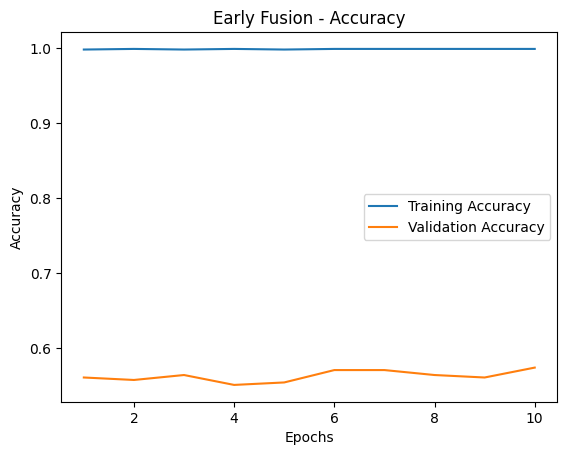

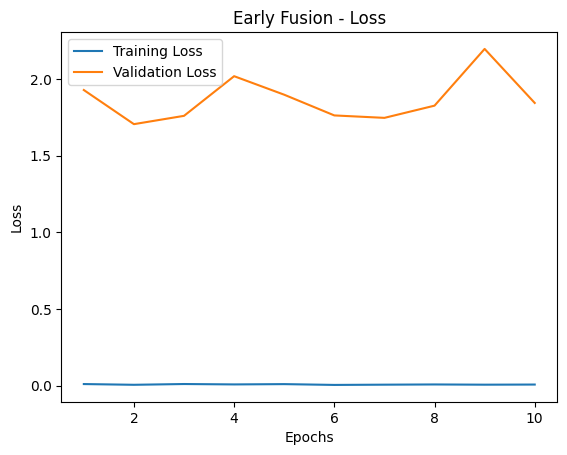

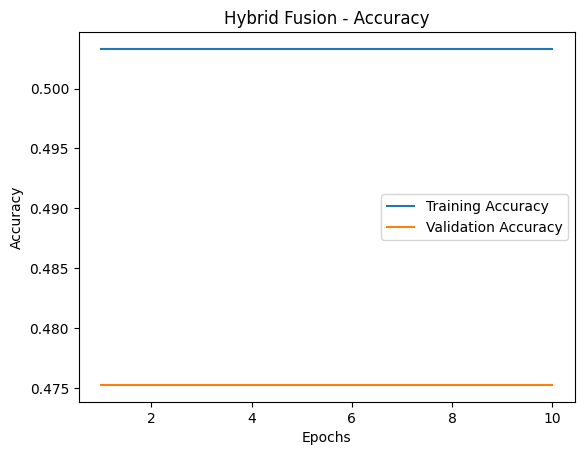

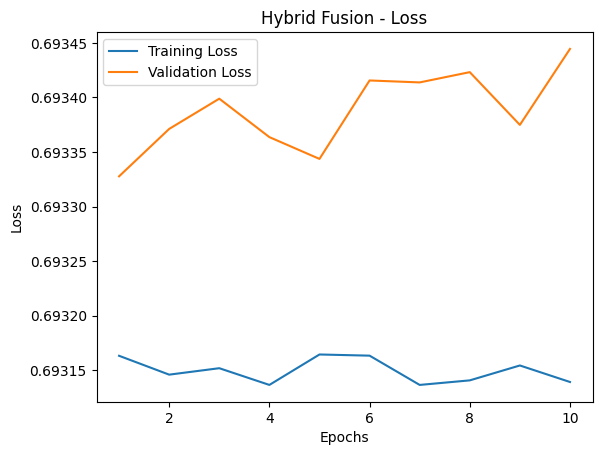

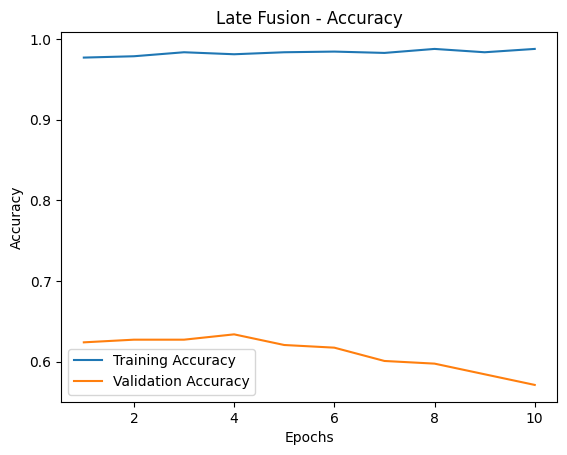

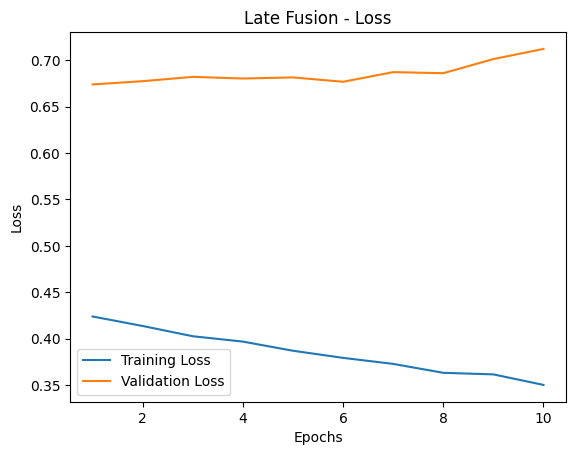

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


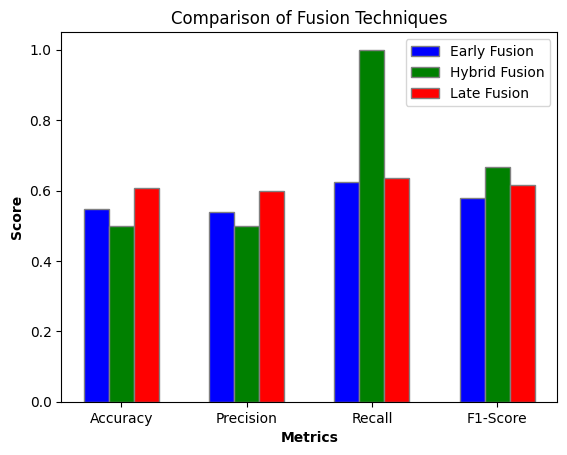

Early Fusion Results: (0.5461741424802111, 0.5388127853881278, 0.6243386243386243, 0.5784313725490197)
Hybrid Fusion Results: (0.49868073878627966, 0.49868073878627966, 1.0, 0.6654929577464789)
Late Fusion Results: (0.6068601583113457, 0.6, 0.6349206349206349, 0.6169665809768637)


In [20]:
### 9. Training and Evaluation with Graphs

import matplotlib.pyplot as plt

# Modify the fit function to store training history (accuracy and loss)
early_history = early_model.fit([X_train_text, X_train_img], y_train, 
                                epochs=10, batch_size=32, validation_split=0.2)

hybrid_history = hybrid_model.fit([X_train_text, X_train_img], y_train, 
                                  epochs=10, batch_size=32, validation_split=0.2)

late_history = late_model.fit([X_train_text, X_train_img], y_train, 
                              epochs=10, batch_size=32, validation_split=0.2)

# 10. Plotting Training Loss and Accuracy
def plot_training_history(history, title):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Plot accuracy
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot training accuracy and loss for Early Fusion, Hybrid Fusion, and Late Fusion
plot_training_history(early_history, "Early Fusion")
plot_training_history(hybrid_history, "Hybrid Fusion")
plot_training_history(late_history, "Late Fusion")

### 11. Evaluation and Comparison of Metrics with Graphs

# Evaluate and compare the models
def evaluate_model(model, X_test_text, X_test_img, y_test):
    predictions = model.predict([X_test_text, X_test_img])
    predictions = np.round(predictions)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    return accuracy, precision, recall, f1

# Comparing Early, Hybrid, and Late Fusion models
early_results = evaluate_model(early_model, X_test_text, X_test_img, y_test)
hybrid_results = evaluate_model(hybrid_model, X_test_text, X_test_img, y_test)
late_results = evaluate_model(late_model, X_test_text, X_test_img, y_test)

# Prepare data for comparison
labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
early_metrics = early_results
hybrid_metrics = hybrid_results
late_metrics = late_results

# Bar plot to compare metrics for each fusion technique
def plot_comparison(early_metrics, hybrid_metrics, late_metrics):
    barWidth = 0.2
    r1 = np.arange(len(labels))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]

    plt.bar(r1, early_metrics, color='b', width=barWidth, edgecolor='grey', label='Early Fusion')
    plt.bar(r2, hybrid_metrics, color='g', width=barWidth, edgecolor='grey', label='Hybrid Fusion')
    plt.bar(r3, late_metrics, color='r', width=barWidth, edgecolor='grey', label='Late Fusion')

    # Add labels and titles
    plt.xlabel('Metrics', fontweight='bold')
    plt.ylabel('Score', fontweight='bold')
    plt.xticks([r + barWidth for r in range(len(labels))], labels)

    plt.title('Comparison of Fusion Techniques')
    plt.legend()
    plt.show()



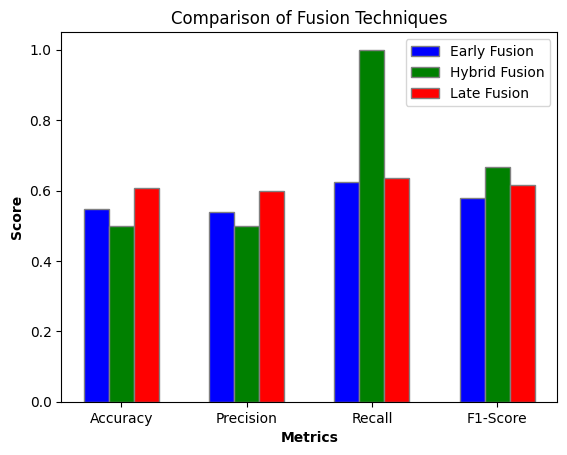

Early Fusion Results: (0.5461741424802111, 0.5388127853881278, 0.6243386243386243, 0.5784313725490197)
Hybrid Fusion Results: (0.49868073878627966, 0.49868073878627966, 1.0, 0.6654929577464789)
Late Fusion Results: (0.6068601583113457, 0.6, 0.6349206349206349, 0.6169665809768637)


In [21]:

# Plot comparison of metrics
plot_comparison(early_metrics, hybrid_metrics, late_metrics)

print("Early Fusion Results:", early_results)
print("Hybrid Fusion Results:", hybrid_results)
print("Late Fusion Results:", late_results)